In [ ]:
import sys
import os
from IPython.display import clear_output
directory = '*main directory here*'
clear_output()

In [ ]:
# t-SNE
!pip install openTSNE
from openTSNE import TSNE

# ResNet
from plotly.graph_objs import *
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

# GANs
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

# Others
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

clear_output()

In [ ]:
# Check whether the specified path exists or not
def create_path(path):
    isExist = os.path.exists(path)
    
    if not isExist:    
        os.makedirs(path)

In [ ]:
#@title Plot t-SNE
def plot_tsne(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):

    if ax is None:
        f, ax = matplotlib.pyplot.subplots(figsize=(15, 15))
        f.set_facecolor('white')

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 10)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
g_lr = 0.0002 
d_lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
to_image = transforms.ToPILImage()
T = transforms.Compose([
  transforms.Resize((image_size, image_size)),
  transforms.CenterCrop(image_size),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = ImageFolder(f'{directory}/Animals/cat-faces', transform=T)
targets = dataset.targets

# Use if dataset is too large and limited memory is available
###########################################
# train_idx, valid_idx = train_test_split(
# np.arange(len(targets)),
# test_size=0.7002,
# shuffle=True,
# stratify=targets)
# train_sampler = torch.utils.data.Subset(dataset, train_idx)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print(f'Total training size: {len(dataloader.dataset)}')

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
# img_list = []
label_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Ca;pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 124 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        # Generated images every  50 epochs, can be modified depending on total epochs
        if (epoch % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

                for i_fake in range(len(fake)):
                    path_directory=f'{directory}/Animals/generated_images/epoch_{epoch}'
                    create_path(path_directory)
                    add_image = fake[i_fake]#.swapaxes(0,1).swapaxes(1,2)
                    save_image(add_image, f'{path_directory}/img_{i_fake}.png')
                    label_list.append(f'epoch_{epoch}')

        iters += 1

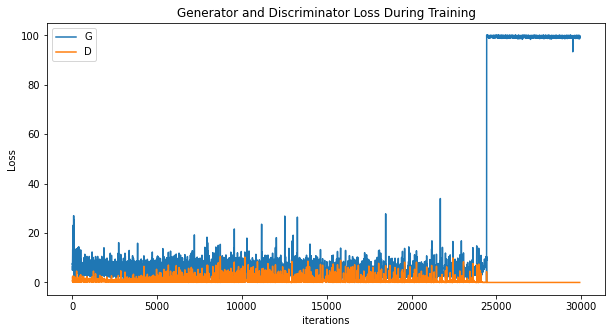

In [ ]:
# Plot the loss for the generator and the discriminator
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Save the trained generator
torch.save(netG.state_dict(), f'{directory}/gan_generated_models/cat_gen.pth')

In [ ]:
#Note: include the generated GAN images to be included in the feature extraction
T = transforms.Compose([

     transforms.Resize((64,64)),

     transforms.ToTensor(),

     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])
dataset = ImageFolder(f'{directory}/Animals/animals-10/', transform=T)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64)

print(f'Total training size: {len(train_loader.dataset)}')

In [ ]:
# Download the ResNet152 model from PyTorch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
# Compute features of each image in the dataset
outputs, labels = get_representations(model.to(device), train_loader)

In [ ]:
tensor_x_path = f'{directory}/x_torch_animals10_resnet50_64_with_gan_epoch_0.pt'
torch.save(outputs, tensor_x_path)

In [ ]:
tsne_input = torch.load(f'{directory}/x_torch_animals10_resnet50_64_with_gan_epoch_0.pt')

In [ ]:
tsne_labels = []
gen_keys = list(train_loader.dataset.class_to_idx.keys())

for label_key in train_loader.dataset.targets:
  tsne_labels.append(gen_keys[label_key])

In [ ]:
tsne_pca = TSNE(
    perplexity=30, 
    initialization='pca', #default
    learning_rate='auto', #default is max(200, n/12)
    early_exaggeration=12, #default
    early_exaggeration_iter=300, #default
    n_iter = 2000,
    n_jobs=8,
    verbose=True
) 

embedding_train_pca = tsne_pca.fit(tsne_input)

In [ ]:
unique, counts = np.unique(tsne_labels, return_counts=True)

print(dict(zip(unique, counts)))

In [ ]:
plot_tsne(embedding_train_pca, tsne_labels, title="")